* Generate graph of true, direct causal connections
* Add transitive edges with some probability
* Add additional false positive edges
* Train to predict either the errors, or the direct edges

In [1]:
import random
import networkx as nx
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
from graph_nets.demos import models
from graph_nets import utils_tf
from scipy import spatial

from IPython.core.debugger import set_trace


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
seed = 2
rand = np.random.RandomState(seed=seed)
DISTANCE_WEIGHT_NAME = "distance"  # The name for the distance edge attribute.

## Create geographic threshold graph

In [3]:
def generate_graph(rand,
                   num_nodes_min_max,
                   dimensions=2,
                   theta=1000.0,
                   rate=1.0):
  """Creates a connected graph.

  The graphs are geographic threshold graphs, but with added edges via a
  minimum spanning tree algorithm, to ensure all nodes are connected.

  Args:
    rand: A random seed for the graph generator. Default= None.
    num_nodes_min_max: A sequence [lower, upper) number of nodes per graph.
    dimensions: (optional) An `int` number of dimensions for the positions.
      Default= 2.
    theta: (optional) A `float` threshold parameters for the geographic
      threshold graph's threshold. Large values (1000+) make mostly trees. Try
      20-60 for good non-trees. Default=1000.0.
    rate: (optional) A rate parameter for the node weight exponential sampling
      distribution. Default= 1.0.

  Returns:
    The graph.
  """
  # Sample num_nodes.
  num_nodes = rand.randint(*num_nodes_min_max)

  # Create geographic threshold graph.
  pos_array = rand.uniform(size=(num_nodes, dimensions))
  pos = dict(enumerate(pos_array))
  weight = dict(enumerate(rand.exponential(rate, size=num_nodes)))
  geo_graph = nx.geographical_threshold_graph(
      num_nodes, theta, pos=pos, weight=weight)

  # Create minimum spanning tree across geo_graph's nodes.
  distances = spatial.distance.squareform(spatial.distance.pdist(pos_array))
  i_, j_ = np.meshgrid(range(num_nodes), range(num_nodes), indexing="ij")
  weighted_edges = list(zip(i_.ravel(), j_.ravel(), distances.ravel()))
  mst_graph = nx.Graph()
  mst_graph.add_weighted_edges_from(weighted_edges, weight=DISTANCE_WEIGHT_NAME)
  mst_graph = nx.minimum_spanning_tree(mst_graph, weight=DISTANCE_WEIGHT_NAME)
  # Put geo_graph's node attributes into the mst_graph.
  for i in mst_graph.nodes():
    mst_graph.node[i].update(geo_graph.node[i])

  # Compose the graphs.
  combined_graph = nx.compose_all((mst_graph, geo_graph.copy()))
  # Put all distance weights into edge attributes.
  for i, j in combined_graph.edges():
    combined_graph.get_edge_data(i, j).setdefault(DISTANCE_WEIGHT_NAME,
                                                  distances[i, j])
  return combined_graph, mst_graph, geo_graph

## Create directed graphs with transitive edges and errors

Each node and/or edges needs a "features" attribute that consists of a vector of floats--this is what is used by Graph Nets/Tensorflow in the fitting operation. In this case, the input graphs have no features; the output graph should have a feature consisting of a boolean variable identifying an edge as a false positive or not.

In [4]:
def get_transitive_edges(g):
    t_edges = []
    for u in g:
        for v in g[u]:
            for w in g[v]:
                t_edges.append((u, w))
    return t_edges

def flip(p):
    return True if random.random() < p else False

def random_edges(g, p):
    edges = []
    for u in g:
        for v in g:
            if flip(p):
                edges.append((u, v))
    return edges

def to_directed(g):
    digraph = nx.DiGraph()
    for u, v in g.edges():
        edge = (u, v) if flip(0.5) else (v, u)
        digraph.add_edge(edge[0], edge[1])
    return digraph

def error_graph(graph):
    digraph = to_directed(graph)
    #graph = add_shortest_path(rand, graph)
    # TODO: Add transitive edges and error edges here TODO
    t_edges = get_transitive_edges(digraph)
    g_trans = nx.DiGraph(digraph)
    g_trans.add_edges_from(t_edges)
    nx.set_edge_attributes(g_trans, True, 'correct')
    g_err = nx.DiGraph(g_trans)
    err_edges = random_edges(g_trans, 0.01)
    g_err.add_edges_from(err_edges, correct=False)
    return g_err

We can see now how a basic undirected geographic threshold graph is turned into a directed graph with transitive and erroneous edges. First, the underlying graph:

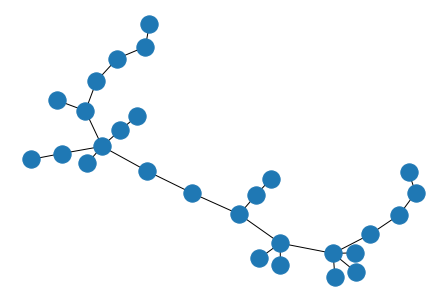

In [5]:
cg, mstg, gg = generate_graph(rand, num_nodes_min_max=(20, 31), dimensions=4, theta=100.0, rate=1.0)
nx.draw(cg)

Now the "error_graph":

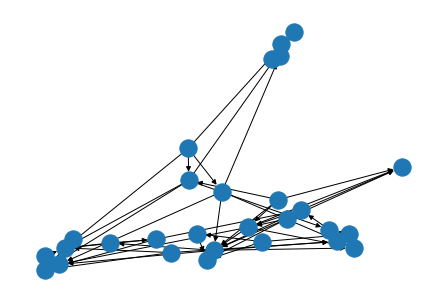

In [6]:
eg = error_graph(cg)
nx.draw(eg)

The number of edges in the graph that are false positives:

In [7]:
err_edges = [(u, v) for u, v, d in eg.edges(data=True) if not d['correct']]
print("Total edges:", len(eg))
print("Errors:", len(err_edges))

Total edges: 28
Errors: 12


## Convert edge attributes to feature vectors

In [8]:
def to_one_hot(indices, max_value, axis=-1):
  one_hot = np.eye(max_value)[indices]
  if axis not in (-1, one_hot.ndim):
    one_hot = np.moveaxis(one_hot, -1, axis)
  return one_hot

def graph_to_input_target(graph):
  """Returns 2 graphs with input and target feature vectors for training.

  Args:
    graph: An `nx.DiGraph` instance.

  Returns:
    The input `nx.DiGraph` instance.
    The target `nx.DiGraph` instance.

  Raises:
    ValueError: unknown node type
  """

  def create_feature(attr, fields):
    if not fields:
        return np.array([0.0])
    return np.hstack([np.array(attr[field], dtype=float) for field in fields])

  #input_node_fields = ("pos", "weight", "start", "end")
  #input_edge_fields = ("distance",)
  input_node_fields = []
  input_edge_fields = []
  target_node_fields = []
  target_edge_fields = ("correct",)

  input_graph = nx.DiGraph()
  target_graph = nx.DiGraph()

  for node_index, node_feature in graph.nodes(data=True):
    input_graph.add_node(
            node_index, features=create_feature(node_feature, input_node_fields))
    target_node_feat = create_feature(node_feature, target_node_fields)
    #if target_node_feat is not None:
    #    target_node_feat = to_one_hot(target_node_feat.astype(int), 2)[0]
    target_graph.add_node(node_index, features=target_node_feat)

  for receiver, sender, features in graph.edges(data=True):
    input_graph.add_edge(
            sender, receiver, features=create_feature(features, input_edge_fields))
    target_edge_feat = create_feature(features, target_edge_fields)
    target_edge_feat = to_one_hot(target_edge_feat.astype(int), 2)[0]       
    target_graph.add_edge(sender, receiver, features=target_edge_feat)

  input_graph.graph["features"] = np.array([0.0])
  target_graph.graph["features"] = np.array([0.0], dtype=float)

  return input_graph, target_graph

In [9]:
ig, tg = graph_to_input_target(eg)
print("Input graph nodes:")
print(sorted(list(ig.nodes(data=True))))
print("Target graph nodes:")
print(sorted(list(tg.nodes(data=True))))

print("Input graph edges:")
print(sorted(list(ig.edges(data=True))))
print()
print("Target graph edges:")
print(sorted(list(tg.edges(data=True))))

Input graph nodes:
[(0, {'features': array([0.])}), (1, {'features': array([0.])}), (2, {'features': array([0.])}), (3, {'features': array([0.])}), (4, {'features': array([0.])}), (5, {'features': array([0.])}), (6, {'features': array([0.])}), (7, {'features': array([0.])}), (8, {'features': array([0.])}), (9, {'features': array([0.])}), (10, {'features': array([0.])}), (11, {'features': array([0.])}), (12, {'features': array([0.])}), (13, {'features': array([0.])}), (14, {'features': array([0.])}), (15, {'features': array([0.])}), (16, {'features': array([0.])}), (17, {'features': array([0.])}), (18, {'features': array([0.])}), (19, {'features': array([0.])}), (20, {'features': array([0.])}), (21, {'features': array([0.])}), (22, {'features': array([0.])}), (23, {'features': array([0.])}), (24, {'features': array([0.])}), (25, {'features': array([0.])}), (26, {'features': array([0.])}), (27, {'features': array([0.])})]
Target graph nodes:
[(0, {'features': array([0.])}), (1, {'feature

## Generate training set graphs

In [10]:
def generate_networkx_graphs(rand, num_examples, num_nodes_min_max, theta):
  """Generate graphs for training.

  Args:
    rand: A random seed (np.RandomState instance).
    num_examples: Total number of graphs to generate.
    num_nodes_min_max: A 2-tuple with the [lower, upper) number of nodes per
      graph. The number of nodes for a graph is uniformly sampled within this
      range.
    theta: (optional) A `float` threshold parameters for the geographic
      threshold graph's threshold. Default= the number of nodes.

  Returns:
    input_graphs: The list of input graphs.
    target_graphs: The list of output graphs.
    graphs: The list of generated graphs.
  """
  input_graphs = []
  target_graphs = []
  graphs = []
    
  for _ in range(num_examples):
    base_graph = generate_graph(rand, num_nodes_min_max, dimensions=4)[0]
    err_graph = error_graph(base_graph)
    input_graph, target_graph = graph_to_input_target(err_graph)
    input_graphs.append(input_graph)
    target_graphs.append(target_graph)
    graphs.append(err_graph)
  return input_graphs, target_graphs, graphs

def create_placeholders(rand, batch_size, num_nodes_min_max, theta):
  """Creates placeholders for the model training and evaluation.

  Args:
    rand: A random seed (np.RandomState instance).
    batch_size: Total number of graphs per batch.
    num_nodes_min_max: A 2-tuple with the [lower, upper) number of nodes per
      graph. The number of nodes for a graph is uniformly sampled within this
      range.
    theta: A `float` threshold parameters for the geographic threshold graph's
      threshold. Default= the number of nodes.

  Returns:
    input_ph: The input graph's placeholders, as a graph namedtuple.
    target_ph: The target graph's placeholders, as a graph namedtuple.
  """
  # Create some example data for inspecting the vector sizes.
  input_graphs, target_graphs, _ = generate_networkx_graphs(
      rand, batch_size, num_nodes_min_max, theta)
  input_ph = utils_tf.placeholders_from_networkxs(input_graphs)
  target_ph = utils_tf.placeholders_from_networkxs(target_graphs)
  return input_ph, target_ph

In [11]:
def create_loss_ops(target_op, output_ops):
  loss_ops = [
      tf.losses.softmax_cross_entropy(target_op.edges, output_op.edges)
      for output_op in output_ops
  ]
  return loss_ops

def make_all_runnable_in_session(*args):
  """Lets an iterable of TF graphs be output from a session as NP graphs."""
  return [utils_tf.make_runnable_in_session(a) for a in args]

In [12]:
#@title Set up model training and evaluation  { form-width: "30%" }

# The model we explore includes three components:
# - An "Encoder" graph net, which independently encodes the edge, node, and
#   global attributes (does not compute relations etc.).
# - A "Core" graph net, which performs N rounds of processing (message-passing)
#   steps. The input to the Core is the concatenation of the Encoder's output
#   and the previous output of the Core (labeled "Hidden(t)" below, where "t" is
#   the processing step).
# - A "Decoder" graph net, which independently decodes the edge, node, and
#   global attributes (does not compute relations etc.), on each
#   message-passing step.
#
#                     Hidden(t)   Hidden(t+1)
#                        |            ^
#           *---------*  |  *------*  |  *---------*
#           |         |  |  |      |  |  |         |
# Input --->| Encoder |  *->| Core |--*->| Decoder |---> Output(t)
#           |         |---->|      |     |         |
#           *---------*     *------*     *---------*
#
# The model is trained by supervised learning. Input graphs are procedurally
# generated, and output graphs have the same structure with the nodes and edges
# of the shortest path labeled (using 2-element 1-hot vectors). We could have
# predicted the shortest path only by labeling either the nodes or edges, and
# that does work, but we decided to predict both to demonstrate the flexibility
# of graph nets' outputs.
#
# The training loss is computed on the output of each processing step. The
# reason for this is to encourage the model to try to solve the problem in as
# few steps as possible. It also helps make the output of intermediate steps
# more interpretable.
#
# There's no need for a separate evaluate dataset because the inputs are
# never repeated, so the training loss is the measure of performance on graphs
# from the input distribution.
#
# We also evaluate how well the models generalize to graphs which are up to
# twice as large as those on which it was trained. The loss is computed only
# on the final processing step.
#
# Variables with the suffix _tr are training parameters, and variables with the
# suffix _ge are test/generalization parameters.
#
# After around 2000-5000 training iterations the model reaches near-perfect
# performance on graphs with between 8-16 nodes.

tf.reset_default_graph()

seed = 2
rand = np.random.RandomState(seed=seed)

# Model parameters.
# Number of processing (message-passing) steps.
num_processing_steps_tr = 10
num_processing_steps_ge = 10

# Data / training parameters.
num_training_iterations = 10000
theta = 20  # Large values (1000+) make trees. Try 20-60 for good non-trees.
batch_size_tr = 32
batch_size_ge = 100
# Number of nodes per graph sampled uniformly from this range.
num_nodes_min_max_tr = (8, 17)
num_nodes_min_max_ge = (16, 33)

# Data.
# Input and target placeholders.
input_ph, target_ph = create_placeholders(rand, batch_size_tr,
                                          num_nodes_min_max_tr, theta)



In [13]:
# Connect the data to the model.
# Instantiate the model.
model = models.EncodeProcessDecode(edge_output_size=2, node_output_size=1)
# A list of outputs, one per processing step.
output_ops_tr = model(input_ph, num_processing_steps_tr)
output_ops_ge = model(input_ph, num_processing_steps_ge)


Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
# Training loss.
loss_ops_tr = create_loss_ops(target_ph, output_ops_tr)
# Loss across processing steps.
loss_op_tr = sum(loss_ops_tr) / num_processing_steps_tr
# Test/generalization loss.
loss_ops_ge = create_loss_ops(target_ph, output_ops_ge)
loss_op_ge = loss_ops_ge[-1]  # Loss from final processing step.

# Optimizer.
learning_rate = 1e-3
optimizer = tf.train.AdamOptimizer(learning_rate)
step_op = optimizer.minimize(loss_op_tr)

# Lets an iterable of TF graphs be output from a session as NP graphs.
input_ph, target_ph = make_all_runnable_in_session(input_ph, target_ph)

In [14]:
#@title Reset session  { form-width: "30%" }

# This cell resets the Tensorflow session, but keeps the same computational
# graph.

try:
  sess.close()
except NameError:
  pass
sess = tf.Session()
sess.run(tf.global_variables_initializer())

last_iteration = 0
logged_iterations = []
losses_tr = []
corrects_tr = []
solveds_tr = []
losses_ge = []
corrects_ge = []
solveds_ge = []

In [ ]:
#@title Run training  { form-width: "30%" }

# You can interrupt this cell's training loop at any time, and visualize the
# intermediate results by running the next cell (below). You can then resume
# training by simply executing this cell again.

# How much time between logging and printing the current results.
log_every_seconds = 20

print("# (iteration number), T (elapsed seconds), "
      "Ltr (training loss), Lge (test/generalization loss), "
      "Ctr (training fraction nodes/edges labeled correctly), "
      "Str (training fraction examples solved correctly), "
      "Cge (test/generalization fraction nodes/edges labeled correctly), "
      "Sge (test/generalization fraction examples solved correctly)")

start_time = time.time()
last_log_time = start_time
for iteration in range(last_iteration, num_training_iterations):
  last_iteration = iteration
  feed_dict, _ = create_feed_dict(rand, batch_size_tr, num_nodes_min_max_tr,
                                  theta, input_ph, target_ph)
  train_values = sess.run({
      "step": step_op,
      "target": target_ph,
      "loss": loss_op_tr,
      "outputs": output_ops_tr
  },
                          feed_dict=feed_dict)
  the_time = time.time()
  elapsed_since_last_log = the_time - last_log_time
  if elapsed_since_last_log > log_every_seconds:
    last_log_time = the_time
    feed_dict, raw_graphs = create_feed_dict(
        rand, batch_size_ge, num_nodes_min_max_ge, theta, input_ph, target_ph)
    test_values = sess.run({
        "target": target_ph,
        "loss": loss_op_ge,
        "outputs": output_ops_ge
    },
                           feed_dict=feed_dict)
    correct_tr, solved_tr = compute_accuracy(
        train_values["target"], train_values["outputs"][-1], use_edges=True)
    correct_ge, solved_ge = compute_accuracy(
        test_values["target"], test_values["outputs"][-1], use_edges=True)
    elapsed = time.time() - start_time
    losses_tr.append(train_values["loss"])
    corrects_tr.append(correct_tr)
    solveds_tr.append(solved_tr)
    losses_ge.append(test_values["loss"])
    corrects_ge.append(correct_ge)
    solveds_ge.append(solved_ge)
    logged_iterations.append(iteration)
    print("# {:05d}, T {:.1f}, Ltr {:.4f}, Lge {:.4f}, Ctr {:.4f}, Str"
          " {:.4f}, Cge {:.4f}, Sge {:.4f}".format(
              iteration, elapsed, train_values["loss"], test_values["loss"],
              correct_tr, solved_tr, correct_ge, solved_ge))